In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using BenchmarkTools
using Statistics
using AdaptiveTransportMap
using JLD
using Test
using Plots
using LaTeXStrings

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


In [3]:
# Define parameters
Ne = 100
Nx = 40
Ny = 20
Δtdyn = 0.05
Δtobs = 0.1

σx = 1e-2
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)
t0 = 0.0
tf = 600.0
Tf = ceil(Int64, tf/Δtobs)

m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx)

f = lorenz96!
h(t,x) = x[1:2:Nx]

model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, 0, 0, 0, f, h);

In [4]:
# Set initial condition
x0 = model.m0 + sqrt(model.C0)*randn(Nx)

# Run dynamics and generate data
data = generate_lorenz96(model, x0, Tf);

In [5]:
# Set initial condition
X = zeros(model.Ny + model.Nx, Ne)
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0

t0 = 0.0
dyn = DynamicalSystem(model.f, model.h)
enkf = StochEnKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, false, false)

Stochastic EnKF  with filtered = false


In [6]:
statehist = seqassim(dyn, data, Tf, model.ϵx, enkf, X, model.Ny, model.Nx, t0);

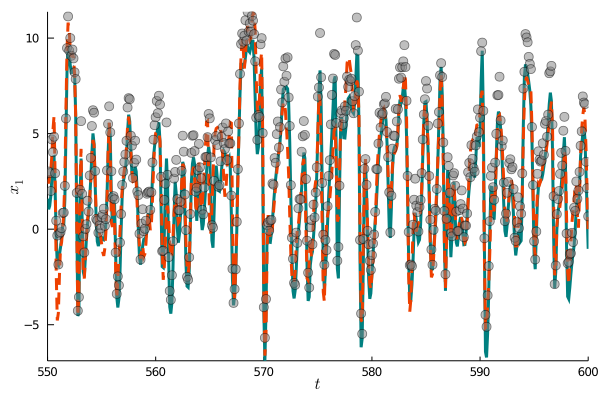

In [7]:
# Plot the first component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1", legend = false)
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal)
plot!(plt, data.tt[nb:Δ:ne], mean_hist(statehist)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, markersize = 3)
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5)
plt

### Benchmark of the EnKF filter

In [8]:
path = "/media/mat/HDD/AdaptiveTransportMap/src/lorenz96/data/"
Nx = 40
Ny = 20
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz96(path, Ne_array);

Ne 10 RMSE: 4.994356288405068
Ne 20 RMSE: 4.640227844966889
Ne 40 RMSE: 3.6515142642911114
Ne 60 RMSE: 1.8611685806349156
Ne 100 RMSE: 0.5083038284353927
Ne 200 RMSE: 0.46546245861792546
 21.692438 seconds (70.67 M allocations: 15.051 GiB, 11.26% gc time)


In [9]:
metric_list = benchmark_lorenz96(model, data, path, [200], [1.01])

(Ne, β) = (200, 1.01)
 16.398326 seconds (63.60 M allocations: 13.674 GiB, 14.44% gc time)
Ne = 200
Ne 200& β 1.01 RMSE: 0.460024993190931


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.333970582127412, 0.43829696141913016, 0.39205865464115525, 0.42275763103688097, 0.5426999297729267, 0.5280721922813296, 0.3576467029031995, 0.388061918774241, 0.3069527345388524, 0.3838223405522232  …  0.31349329603088594, 0.539577031890609, 0.39252184225134956, 0.39277393325004323, 0.441501710721378, 0.39319053401545917, 0.4117492447122511, 0.3280115348482089, 0.5576597267973467, 0.5104989971703975], 0.43318578980556555, 0.460024993190931, 0.14688488761419793, [0.6774995570973481, 0.7025567540802966, 0.7004744421394128, 0.6238345156964725, 0.6826260678998174, 0.6984755999828115, 0.7211902722599998, 0.7183932702757668, 0.6974759546377782, 0.6615750831083523  …  0.6237996895010384, 0.6608658513905776, 0.7090749971003028, 0.6902679686830439, 0.6757820179615831, 0.663303305083236, 0.6956405501227917, 0.8075874185488788, 0.9395009015953273, 0.8685582350286368], 0.7140217939900708, 0.7314965317699825, 0.121968661970722, [1.0, 1.0, 1.0, 1.0, 0

In [10]:
data.tt

6000-element Array{Float64,1}:
    0.4
    0.8
    1.2000000000000002
    1.6
    2.0
    2.4000000000000004
    2.8000000000000003
    3.2
    3.6
    4.0
    4.4
    4.800000000000001
    5.2
    ⋮
 2395.6
 2396.0
 2396.4
 2396.8
 2397.2000000000003
 2397.6
 2398.0
 2398.4
 2398.8
 2399.2000000000003
 2399.6
 2400.0